In [17]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from keras.preprocessing.text import Tokenizer
#import tensorflow_text as text
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
data = pd.read_csv("spring/total.csv",encoding='utf-8')

In [4]:
data["categorias"] = data["categorias"].apply(
    lambda x: literal_eval(x)
)

In [5]:
terms = tf.ragged.constant(data["categorias"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

In [6]:
len(vocab)

104

In [7]:
test_split = 0.2

# Initial train and test split.
train_df, test_df = train_test_split(
    data,
    test_size=test_split,
    stratify=data["categorias"].values,
)

In [8]:
vocabulary = set()
train_df["abstract"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

99799


In [9]:
data["abstract"].apply(lambda x: len(x.split(" "))).describe()

count    21516.000000
mean       181.068786
std         68.810352
min          1.000000
25%        139.000000
50%        178.000000
75%        221.000000
max       1184.000000
Name: abstract, dtype: float64

In [10]:
max_seqlen = 178
batch_size = 110
padding_token = "<pad>"
auto = tf.data.AUTOTUNE
max_vocabulary_size = 100
def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["categorias"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["abstract"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [11]:
train_dataset = make_dataset(train_df, is_train=True)
test_dataset = make_dataset(test_df, is_train=False)

In [12]:
text_vectorizer = layers.TextVectorization(
    max_tokens=max_vocabulary_size, ngrams=2, output_mode="tf_idf"
)
with tf.device("/CPU:0"):
    text_vectorizer.adapt(data["abstract"])
train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=max_vocabulary_size,
        output_dim=120,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5),
    layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
])

In [14]:
model.compile(loss='kullback_leibler_divergence',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy',"binary_accuracy"])

In [15]:
with tf.device("/GPU:0"):
    history = model.fit(train_dataset, epochs=5,
                        validation_data=test_dataset,
                        validation_steps=30)

Epoch 1/5
157/157 [==============================] - 299s 2s/step - loss: 2.0783 - accuracy: 0.0041 - binary_accuracy: 0.4360 - val_loss: 1.6083 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.2920
Epoch 2/5
157/157 [==============================] - 281s 2s/step - loss: 1.4372 - accuracy: 0.0149 - binary_accuracy: 0.2572 - val_loss: 1.1326 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.0840
Epoch 3/5
157/157 [==============================] - 281s 2s/step - loss: 1.0252 - accuracy: 0.0166 - binary_accuracy: 0.1367 - val_loss: 0.7532 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.0292
Epoch 4/5
157/157 [==============================] - 282s 2s/step - loss: 0.7041 - accuracy: 0.0188 - binary_accuracy: 0.0718 - val_loss: 0.4919 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.0288
Epoch 5/5
157/157 [==============================] - 282s 2s/step - loss: 0.4891 - accuracy: 0.0159 - binary_accuracy: 0.0448 - val_loss: 0.3321 - val_accuracy: 0.0000e+00 - val_binary_accurac

In [18]:
keras.models.save_model(model,'spring/radEd_model_v3.hdf5')
#shallow_mlp_model = tf.keras.models.load_model('spring/radEd_model_v3.hdf5')

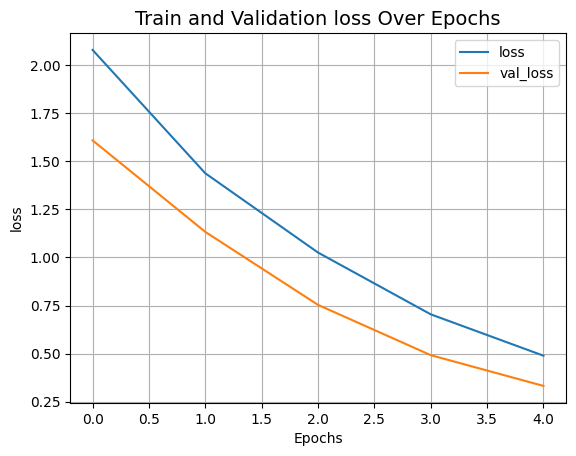

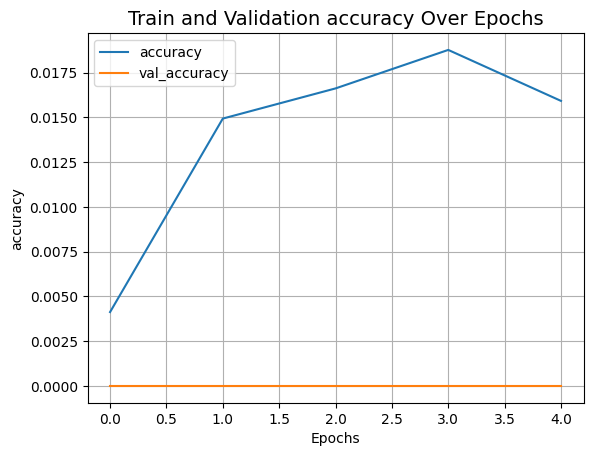

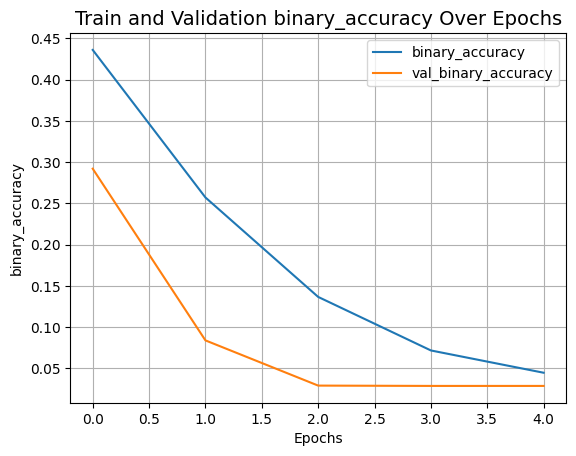

In [19]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")
plot_result("binary_accuracy")

In [ ]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:3]):
    label = label_batch[i].numpy()[None, ...]
    #print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")